# Tutorial for further topics about density ridge analysis

This jupyter notebook introduces further details about density ridge analysis, including performing statistical inference.

Many single cell data analysis tasks can be addressed in the density ridge estimation framework. For example trajectory analysis can be considered identifying one-dimensional density ridge, clustering analysis as zero-dimensional density ridge, and 2D-surface analysis as two-dimensional density ridges.

Density ridges are generalizations of local maxima in density functions, which are mathematically defined based on the density function. The algorithm to idenfity density ridges - SCMS, project data points / cells onto corresponding positions in the density ridge.

In [15]:
from quasildr.dridge import *
data = np.loadtxt('../example/hsmm.simple',delimiter='\t').T
s = Scms(data[:,:],0.5,min_radius=0)


n_iterations = 300
shifted = data.copy()

allshiftedx = np.zeros((data.shape[0],n_iterations))
allshiftedy = np.zeros((data.shape[0],n_iterations))

for j in range(n_iterations):
    allshiftedx[:,j] = shifted[:,0]
    allshiftedy[:,j] = shifted[:,1]
    shifted += 1*s.scms_update(shifted,method='LocInv',stepsize=0.2)[0]

    
    
    
#visualize with bokeh plotting
import bokeh
from bokeh.plotting import figure, reset_output, output_file, output_notebook, show, ColumnDataSource
from bokeh.io import export_svgs

reset_output()
from bokeh.resources import INLINE
output_notebook(INLINE)
from bokeh.models.glyphs import *

p = figure(plot_width=500, plot_height=500, title="Data Projection",
           toolbar_location=None, tools="")
p.output_backend = "svg"

p.scatter(data[:,0],data[:,1],
        fill_color='#CCCCCC',
    line_color=None, name="90% confidence set")

source = ColumnDataSource(dict(
    xs=[x for x in allshiftedx],
    ys=[y for y in allshiftedy],
))

glyph = MultiLine(xs="xs", ys="ys", line_color='#888888', line_alpha=0.8)
p.add_glyph(source, glyph)


p.scatter(allshiftedx[:,-1],allshiftedy[:,-1],fill_color="steelblue")
show(p)

Loading BokehJS ...

It is also possible to project point / cell state that is not included in the original data to the trajectories, given the density function estimation from original data points:

In [20]:

n_iterations = 300
xv, yv = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-3.5, 0.5, 20), sparse=False, indexing='ij')
grid = np.column_stack([np.concatenate(xv),np.concatenate(yv)])


p, g, h, _ = s._kernel_density_estimate(grid)
ifilter = np.where(p >= (np.max(p)*0.05))[0]

shifted = grid[ifilter,:].copy()
allshiftedx_grid = np.zeros((shifted.shape[0],n_iterations))
allshiftedy_grid = np.zeros((shifted.shape[0],n_iterations))

for j in range(n_iterations):
    allshiftedx_grid[:,j] = shifted[:,0]
    allshiftedy_grid[:,j] = shifted[:,1]
    shifted += 1*s.scms_update(shifted,method='GradientLogp',stepsize=0.02)[0]


p = figure(plot_width=500, plot_height=500, title="Data Projection",
           toolbar_location=None, tools="")
p.output_backend = "svg"

p.scatter(grid[:,0],grid[:,1],
        fill_color='#CCCCCC',
    line_color=None)

source = ColumnDataSource(dict(
    xs=[x for x in allshiftedx_grid],
    ys=[y for y in allshiftedy_grid],
))

glyph = MultiLine(xs="xs", ys="ys", line_color='#888888', line_alpha=0.8)
p.add_glyph(source, glyph)

p.scatter(allshiftedx_grid[:,-1],allshiftedy_grid[:,-1],fill_color="steelblue")
show(p)

You can skip block this unless you are interested in the inner mechanism of the SCMS algorithm. 

The SCMS algorithm is basically a projected gradient ascent method, as depicted in the figure below: the black arrows indicates the projected gradient, while the gray arrows indicate the original gradient of the log density function. The black bars indicates the first eigenvector of the Hessian matrix of the log density function. Projecting out the gradient of the first eigenvector gives algorithm that converges to 1D density ridges, and projecting out first two eigenvectors gives algorithm that converges to 2D density ridges, etc.

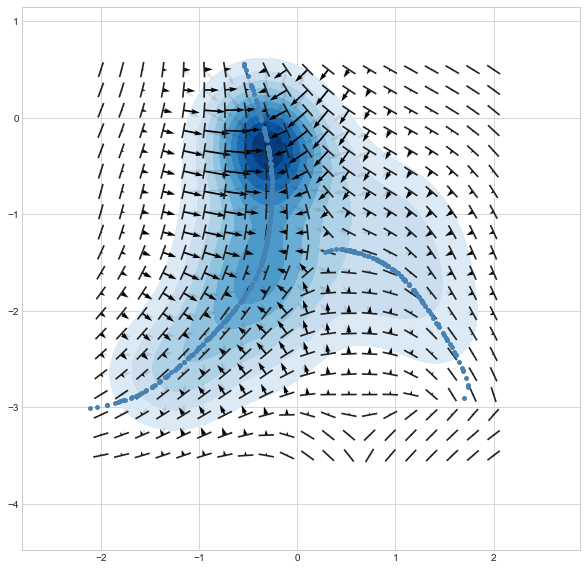

In [25]:
from matplotlib import pyplot as plt
%matplotlib inline

h, _, g, _, msu = s._nlocal_inv_cov(grid)
eigvals, eigvecs = np.linalg.eigh(-h)
eigvals = -eigvals

h2 = eigvecs.copy()
h2[:,:,0]=0
from numpy.core.umath_tests import matrix_multiply
g2 = matrix_multiply(matrix_multiply(h2, h2.transpose((0, 2, 1))), g[:, :, np.newaxis])[:,:,0]

import seaborn as sns
sns.set_style("whitegrid")
fig = plt.figure(figsize=(10,10))
sns.kdeplot(data[:,0],data[:,1],bw=(0.35,0.35),cmap='Blues',n_levels=10,shade=True, shade_lowest=False)
plt.quiver(grid[:,0], grid[:,1],g[:,0],g[:,1],color='#000000',alpha=0.1,scale=7)
plt.quiver(grid[:,0], grid[:,1],g2[:,0],g2[:,1],color='#000000',scale=7)
plt.quiver(grid[:,0], grid[:,1],eigvecs[:,0,0],eigvecs[:,1,0], headlength=0, color='#222222', pivot='middle',headaxislength=0)
plt.scatter(allshiftedx_grid[:,-1],allshiftedy_grid[:,-1],color='steelblue',s=15)


## Statistical inference via bootstrap 

The simple and deterministic definition of density ridge allows performing bootstrap to construct confidence set for density ridge positions, based on the work by Chen et al. 2015, Ann. Statist.

Bootstrap resampling requires representation of each cell to be independent. We therefore use linear representation via PCA. We use the Trapnell et.al. 2014 myoblast dataset for demonstration.

In [6]:

z, ifilter = s.scms(data, ridge_dimensionality=1,threshold=0.,method='LocInv',n_iterations=50,stepsize=1,n_jobs=1,relaxation=0)
s.boostrap_trajectory(n_bootstrap=100,n_jobs=50)

#95% confidence set
dball_ns = np.percentile(s.bootstrap_distances_n,95,axis=1)


In [7]:


p = figure(plot_width=500, plot_height=500, title="Uncertainty estimates",
           toolbar_location=None, tools="")
p.output_backend = "svg"

p.scatter(z[:,0],z[:,1],radius=dball_ns, radius_units="data",
        fill_color='#CCCCCC',
    line_color=None, name="90% confidence set")
palette = list(reversed(['#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'
]))
local_uncertainty = dball_ns
low = min(dball_ns)
high= max(dball_ns)
local_uncertainty_inds = [int(8*(x-low)/(high-low)) for x in local_uncertainty] #gives items in colors a value from 0-10
local_uncertainty_colors = [palette[i] for i in local_uncertainty_inds]

p.scatter(z[:,0],z[:,1], color=local_uncertainty_colors, line_color=None)
show(p)

Loading BokehJS ...

This confidence set is established for the density ridge positions of smoothed true density function with the kernel specified. The users should refer to Chen et al. 2014 for interpretation of the confidence set.

In addition, specifying a density threshold via `threshold` argument to filter out low density area points may be required to filter out low-quality estimations (`threshold=0.05` is used in the original publication).